In [1]:
modelIn = "microsoft/Multilingual-MiniLM-L12-H384"
                                              # "cmarkea/distilcamembert-base-sentiment"
                                              # "cmarkea/distilcamembert-base" (accuracy=0,69)
                                              # "camembert-base"
                                              # "microsoft/Multilingual-MiniLM-L12-H384" (accuracy=0,64)
                                              # "nlptown/bert-base-multilingual-uncased-sentiment"
                                              # "distilbert-base-uncased-finetuned-sst-2-english"
                                              # "bert-base-uncased"
                                              # "bert-base-cased"
problem_type =  "regression"                  # Possible values: "regression", "single_label_classification", "multi_label_classification"
num_labels = 1

dataCuratedPath = "Data/Curated"              # Columns separated by ";" to avoid numeric formats nightmare:
                                              #    'postText', 'targetTitle', 'targetDescription', 'id', 'truthMean
inputColumn = 'postText'
actualOutput = 'truthMean'
computedOutput = "labelC"

removeColumns = ['postText', 'targetTitle', 'targetDescription', 'id', 'truthMean']

push_to_hub = False                           # Push to Huggingface

splitFactor = 0.2                             # Part of the data for the tests
learning_rate = 5e-5
weight_decay=0.01

useExtra = True                               # Use extra set not used in the competition
phase = 1                                     # Script will be used two times

modelSuffix = "(Labels={0} Rate={1} Decay={2} Phase={3})".format(num_labels, learning_rate, weight_decay, phase)
modelOut = "Models/" + modelIn.replace("/", "-") + "-clickbait" + modelSuffix

In [2]:
import torch
import numpy as np

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained(modelIn)
model = AutoModelForSequenceClassification.from_pretrained(
   modelIn,
   problem_type=problem_type,
   num_labels = num_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/Multilingual-MiniLM-L12-H384 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(250037, 384, padding_idx=0)
      (position_embeddings): Embedding(512, 384)
      (token_type_embeddings): Embedding(2, 384)
      (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (LayerNorm): LayerNorm((384,), eps=1e-12, elemen

In [5]:
if phase==2:
    for param in model.bert.embeddings.parameters():
        param.requires_grad = False

    for param in model.bert.encoder.layer.parameters():
        param.requires_grad = False

In [6]:
import datasets as ds

In [7]:
curated = ds.load_from_disk(dataCuratedPath)

In [8]:
curated.to_pandas()

,postText,targetTitle,targetDescription,truthMean,id
0,"Panama Papers: Europol links 3,500 names to su...","Panama Papers: Europol links 3,500 names to su...",Law enforcement agency analysis uncovers proba...,0.066667,804113781580328960
1,The key to truly great chicken soup,A Superior Chicken Soup,For the best rendition of this American classi...,0.733333,804119512010424320
2,Afghan policewomen face down their fears to serve,100 Women 2016: On the frontline with the wome...,The Afghan women risking all to join the police.,0.333333,804121272967983104
3,Conservatives are watching less football this ...,Older Viewers and Conservatives Are Watching L...,"Many factors are dragging down NFL ratings, in...",0.066667,804123103995580416
4,Richard Sherman weighs in on Cam Newton’s stru...,Seattle Seahawks Richard Sherman Says 'Karma' ...,"Seattle Seahawks news, rumors, scores, schedul...",0.133333,804126501117435904
...,...,...,...,...,...
21992,Petition calling for Kay Burley's sacking reac...,Petition to sack Kay Burley following Alton To...,A petition calling for the sacking of Sky News...,0.000000,610200047951609857
21993,RT @BuzzFeedNews: This Trooper Pulled Over An ...,An Old Lady In A Scooter Was Lost On A Highway...,,0.400000,610200274658029568
21994,"RT @irin: No one can ever top this sentence, a...",Rich Californians balk at limits: ‘We’re not a...,"After years of devastating drought, ultra-weal...",0.666667,610201503752658944
21995,VIDEO: ESPN's OTL study reveals that college a...,OTL Investigates Perception of Top College Ath...,ESPN's Outside the Lines conducted a study...,0.200000,610201840836186112


In [9]:
if (not useExtra):
    curated=curated.filter(lambda example: example['id'].startswith('8'))

In [11]:

curated=curated.filter(lambda example: len(example['postText'])>0)

100%|██████████| 22/22 [00:00<00:00, 40.76ba/s]


In [12]:
longueur= len(curated)
longueur

21943

In [13]:
curatedSorted=sorted(curated[actualOutput])

In [14]:
import matplotlib.pyplot as plt

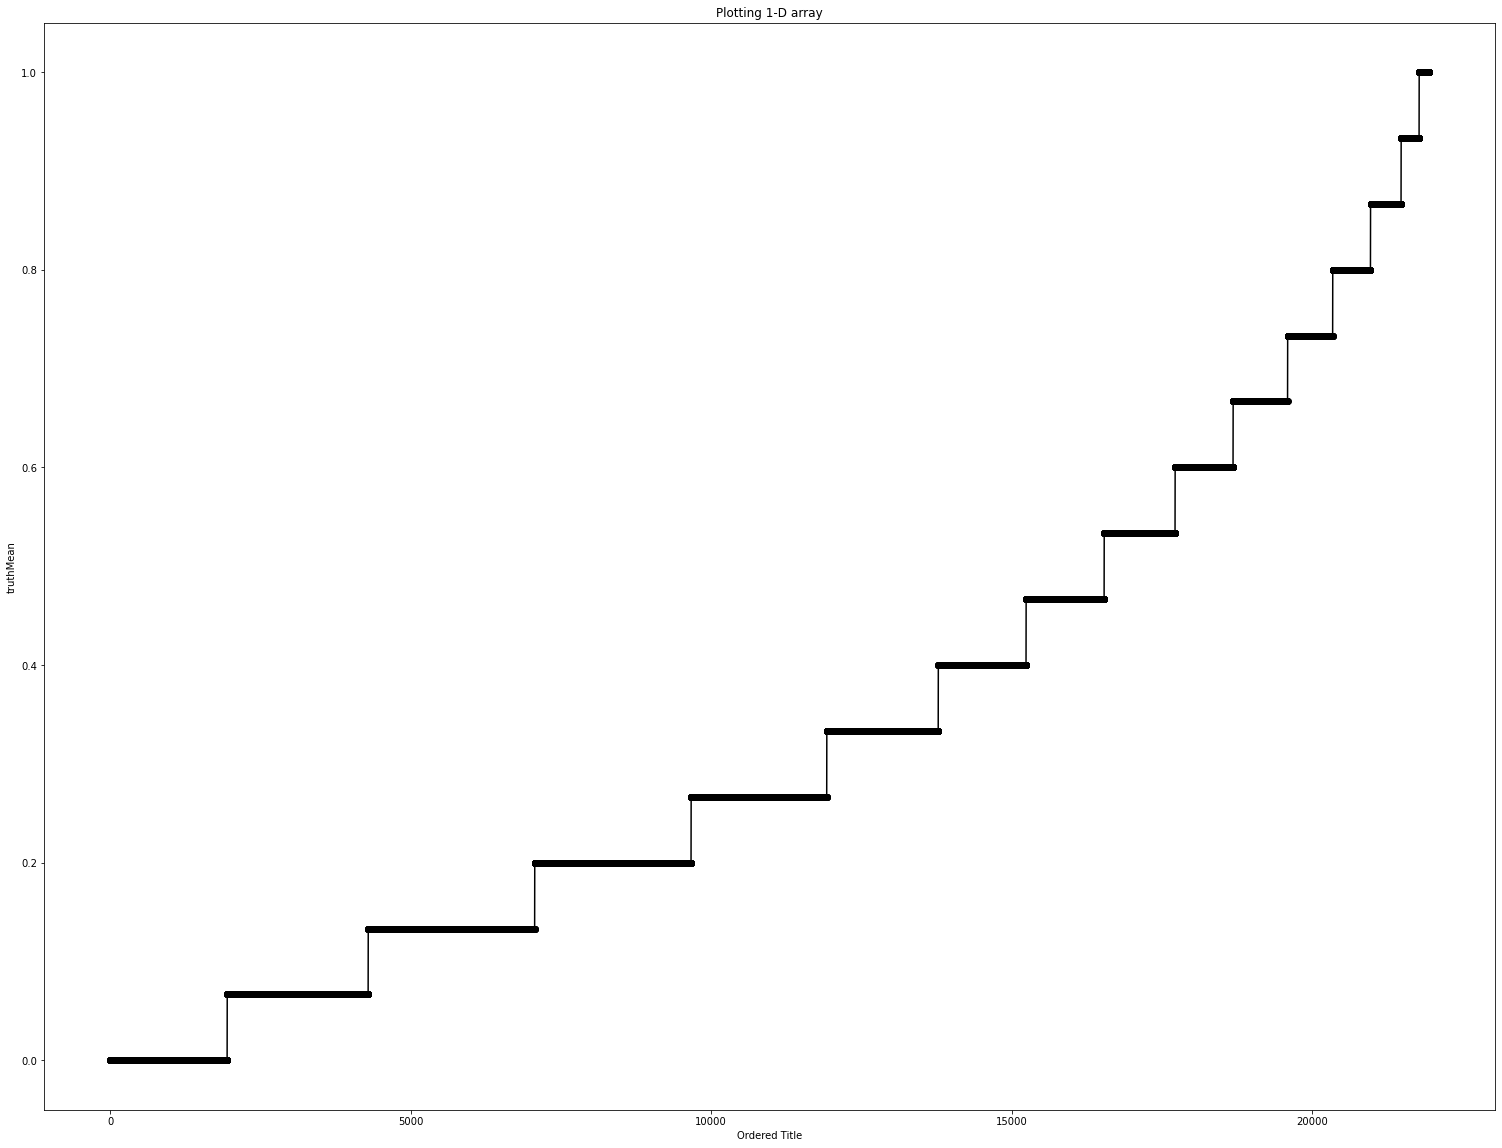

In [15]:
plt.figure(figsize=(26, 20))
plt.title("Plotting 1-D array")
plt.xlabel("Ordered Title")
plt.ylabel(actualOutput)
x = np.array(range(0, longueur))
y = np.array(curatedSorted)
plt.plot(x, y, color = "black", marker = "o", label = "Array elements")

In [16]:
if num_labels > 1:
    ncf=[None] * (num_labels-1)
    for i in range(num_labels-1):
        ncf[i] = curatedSorted[longueur * (i+1) // num_labels]
    ncf

In [17]:
def tokenize(sample):
    tokenized_sample = tokenizer(sample[inputColumn])

    fraction = sample[actualOutput]
    
    if num_labels == 1:
        tokenized_sample["labels"] = fraction
    else:
        tokenized_sample["labels"] = next((x for x, val in enumerate(ncf) if fraction < val), num_labels-1)
    
    return tokenized_sample

In [18]:
tokenized_curated = curated.map(tokenize) #, batched=True)

100%|██████████| 21943/21943 [00:08<00:00, 2725.92ex/s]


In [19]:
tokenized_curated

Dataset({
    features: ['postText', 'targetTitle', 'targetDescription', 'truthMean', 'id', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 21943
})

In [20]:
tokenized_curated.to_pandas()

,postText,targetTitle,targetDescription,truthMean,id,input_ids,attention_mask,labels
0,"Panama Papers: Europol links 3,500 names to su...","Panama Papers: Europol links 3,500 names to su...",Law enforcement agency analysis uncovers proba...,0.066667,804113781580328960,"[0, 149674, 62323, 7, 12, 3939, 5877, 22317, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.066667
1,The key to truly great chicken soup,A Superior Chicken Soup,For the best rendition of this American classi...,0.733333,804119512010424320,"[0, 581, 22799, 47, 87607, 6782, 143896, 10108...","[1, 1, 1, 1, 1, 1, 1, 1, 1]",0.733333
2,Afghan policewomen face down their fears to serve,100 Women 2016: On the frontline with the wome...,The Afghan women risking all to join the police.,0.333333,804121272967983104,"[0, 57351, 1121, 35206, 3613, 1055, 2577, 7565...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.333333
3,Conservatives are watching less football this ...,Older Viewers and Conservatives Are Watching L...,"Many factors are dragging down NFL ratings, in...",0.066667,804123103995580416,"[0, 78771, 42991, 621, 100244, 40715, 101740, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.066667
4,Richard Sherman weighs in on Cam Newton’s stru...,Seattle Seahawks Richard Sherman Says 'Karma' ...,"Seattle Seahawks news, rumors, scores, schedul...",0.133333,804126501117435904,"[0, 22758, 53257, 669, 642, 6958, 7, 23, 98, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.133333
...,...,...,...,...,...,...,...,...
21938,Petition calling for Kay Burley's sacking reac...,Petition to sack Kay Burley following Alton To...,A petition calling for the sacking of Sky News...,0.000000,610200047951609857,"[0, 75362, 1830, 159029, 100, 26125, 7362, 429...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.000000
21939,RT @BuzzFeedNews: This Trooper Pulled Over An ...,An Old Lady In A Scooter Was Lost On A Highway...,,0.400000,610200274658029568,"[0, 27389, 1374, 7235, 13894, 30154, 297, 2241...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.400000
21940,"RT @irin: No one can ever top this sentence, a...",Rich Californians balk at limits: ‘We’re not a...,"After years of devastating drought, ultra-weal...",0.666667,610201503752658944,"[0, 27389, 1374, 41503, 12, 438, 1632, 831, 17...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.666667
21941,VIDEO: ESPN's OTL study reveals that college a...,OTL Investigates Perception of Top College Ath...,ESPN's Outside the Lines conducted a study...,0.200000,610201840836186112,"[0, 14483, 12, 57898, 839, 25, 7, 180, 41445, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.200000


In [22]:
tokenized_curated2 = tokenized_curated.train_test_split(splitFactor) # 0.2

In [23]:
tokenized_curated2['train'].to_pandas()

,postText,targetTitle,targetDescription,truthMean,id,input_ids,attention_mask,labels
0,San Francisco Fed President John Williams sees...,Fed’s Williams Sees Three-Hike 2017 Outlook as...,Three interest-rate increases this year is a “...,0.133333,817105613427773441,"[0, 1735, 22600, 80799, 34202, 4939, 40478, 40...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.133333
1,White House to spin failure of health care bil...,White House To Spin Failure Of Health Care Bil...,"With the deal in doubt, Trump is taking his ba...",0.200000,845323299043381250,"[0, 22392, 13038, 47, 25927, 137578, 111, 1622...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.200000
2,MORE: Berlin police say suspect arrested near ...,Truck plows through crowd at Christmas market ...,There have long been warnings that outdoor fes...,0.400000,810960787602894848,"[0, 195879, 12, 10271, 35206, 5154, 92610, 347...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.400000
3,Here are 6 #LGBTQ events worth traveling for i...,6 LGBTQ Events Worth Traveling for in 2017,"From Miami to Sydney, there's no shortage of t...",0.466667,817425792112201731,"[0, 11853, 621, 305, 468, 188752, 2737, 47353,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.466667
4,Church accuses Mexicans who work on Trump wall...,Church accuses Mexicans who work on Trump wall...,The Roman Catholic Archdiocese of Mexico has c...,0.266667,846391378980454400,"[0, 84084, 61689, 5908, 181815, 7, 2750, 4488,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.266667
...,...,...,...,...,...,...,...,...
17549,Harry Styles' biggest #SignoftheTimes influences,Harry Styles' Biggest 'Sign of the Times' Infl...,"Harry Styles' first single, ""Sign of the Times...",0.266667,850800519484514304,"[0, 20904, 57845, 7, 25, 129058, 468, 218723, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.266667
17550,"RT @ThisIsFusion: 10,000 people marched agains...",Nicaraguan campesinos tell Ortega to take his ...,"JUIGALPA, Nicaragua — Under the blue-and-white...",0.133333,610192856217747456,"[0, 27389, 1374, 73243, 29598, 80163, 6889, 12...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.133333
17551,A raptor strikes at sunset,A raptor strikes at sunset,"Country Diary: Langstone, Hampshire As the spa...",0.333333,819782361751502848,"[0, 62, 29892, 1290, 153350, 7, 99, 4262, 3509...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.333333
17552,The intriguing conspiracy theory why the White...,The intriguing conspiracy theory why the White...,"On Tuesday, MSNBC’s Rachael Maddow announced s...",0.266667,843044308324249600,"[0, 581, 102007, 34, 214, 180255, 2408, 154453...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.266667


In [24]:
tokenized_curated3 = tokenized_curated2.remove_columns(removeColumns)

In [25]:
tokenized_curated4 = tokenized_curated3

In [26]:
tokenized_curated4

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 17554
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 4389
    })
})

In [27]:
from transformers import TrainingArguments

In [28]:
training_args = TrainingArguments(modelOut,
                                  evaluation_strategy= "steps", # "epoch",
                                  eval_steps = 50, # Evaluation happens every 50 steps
                                  save_steps = 50, # Save happens every 50 steps
                                  save_total_limit = 10, # Only last 10 models are saved. Older ones are deleted.
                                  num_train_epochs = 4,
                                  optim= 'adamw_torch',
                                  per_device_train_batch_size = 16,
                                  per_device_eval_batch_size = 16,
                                  learning_rate=learning_rate,
                                  weight_decay=weight_decay,
                                  push_to_hub=(push_to_hub & phase==2),
                                  load_best_model_at_end=True
                                 )

In [29]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer)

In [30]:
from transformers import Trainer
from transformers import EarlyStoppingCallback

trainer = Trainer(model,
                  training_args,
                  train_dataset=tokenized_curated4["train"],
                  eval_dataset=tokenized_curated4["test"],
                  data_collator=data_collator,
                  tokenizer=tokenizer,
                  callbacks = [EarlyStoppingCallback(early_stopping_patience=10)],
                 )

Main training loop

In [31]:
if (modelIn != modelOut):
    trainer.train()

***** Running training *****
  Num examples = 17554
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 4392
  1%|          | 50/4392 [00:10<06:43, 10.75it/s] ***** Running Evaluation *****
  Num examples = 4389
  Batch size = 16

  1%|          | 50/4392 [00:16<06:43, 10.75it/s]Saving model checkpoint to Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-50
Configuration saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-50\config.json


{'eval_loss': 0.039546940475702286, 'eval_runtime': 5.6976, 'eval_samples_per_second': 770.325, 'eval_steps_per_second': 48.266, 'epoch': 0.05}


Model weights saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-50\pytorch_model.bin
tokenizer config file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-50\tokenizer_config.json
Special tokens file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-50\special_tokens_map.json
  2%|▏         | 100/4392 [00:27<06:37, 10.79it/s] ***** Running Evaluation *****
  Num examples = 4389
  Batch size = 16
                                                  
  2%|▏         | 100/4392 [00:32<06:37, 10.79it/s]Saving model checkpoint to Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-100
Configuration saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-100\config.json


{'eval_loss': 0.03212834894657135, 'eval_runtime': 5.6152, 'eval_samples_per_second': 781.622, 'eval_steps_per_second': 48.974, 'epoch': 0.09}


Model weights saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-100\pytorch_model.bin
tokenizer config file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-100\tokenizer_config.json
Special tokens file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-100\special_tokens_map.json
  3%|▎         | 150/4392 [00:44<07:56,  8.91it/s]  ***** Running Evaluation *****
  Num examples = 4389
  Batch size = 16
                                                  
  3%|▎         | 150/4392 [00:51<07:56,  8.91it/s]Saving model checkpoint to Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-150
Configuration saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-150\config.json


{'eval_loss': 0.03266841545701027, 'eval_runtime': 6.8498, 'eval_samples_per_second': 640.749, 'eval_steps_per_second': 40.147, 'epoch': 0.14}


Model weights saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-150\pytorch_model.bin
tokenizer config file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-150\tokenizer_config.json
Special tokens file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-150\special_tokens_map.json
  5%|▍         | 199/4392 [01:04<07:07,  9.81it/s]  ***** Running Evaluation *****
  Num examples = 4389
  Batch size = 16
                                                  
  5%|▍         | 200/4392 [01:10<07:07,  9.81it/s]Saving model checkpoint to Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-200
Configuration saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-200\config.json


{'eval_loss': 0.02841087430715561, 'eval_runtime': 5.8618, 'eval_samples_per_second': 748.742, 'eval_steps_per_second': 46.914, 'epoch': 0.18}


Model weights saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-200\pytorch_model.bin
tokenizer config file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-200\tokenizer_config.json
Special tokens file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-200\special_tokens_map.json
  6%|▌         | 250/4392 [01:21<06:27, 10.70it/s]  ***** Running Evaluation *****
  Num examples = 4389
  Batch size = 16
                                                  
  6%|▌         | 250/4392 [01:26<06:27, 10.70it/s]Saving model checkpoint to Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-250
Configuration saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-250\config.json


{'eval_loss': 0.028282439336180687, 'eval_runtime': 5.7218, 'eval_samples_per_second': 767.06, 'eval_steps_per_second': 48.061, 'epoch': 0.23}


Model weights saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-250\pytorch_model.bin
tokenizer config file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-250\tokenizer_config.json
Special tokens file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-250\special_tokens_map.json
  7%|▋         | 300/4392 [01:38<06:26, 10.58it/s]  ***** Running Evaluation *****
  Num examples = 4389
  Batch size = 16
                                                  
  7%|▋         | 300/4392 [01:43<06:26, 10.58it/s]Saving model checkpoint to Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-300
Configuration saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-300\config.json


{'eval_loss': 0.028778765350580215, 'eval_runtime': 5.7885, 'eval_samples_per_second': 758.229, 'eval_steps_per_second': 47.508, 'epoch': 0.27}


Model weights saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-300\pytorch_model.bin
tokenizer config file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-300\tokenizer_config.json
Special tokens file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-300\special_tokens_map.json
  8%|▊         | 349/4392 [01:55<06:48,  9.89it/s]  ***** Running Evaluation *****
  Num examples = 4389
  Batch size = 16
                                                  
  8%|▊         | 350/4392 [02:01<06:48,  9.89it/s]Saving model checkpoint to Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-350
Configuration saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-350\config.json


{'eval_loss': 0.02925700880587101, 'eval_runtime': 5.8954, 'eval_samples_per_second': 744.482, 'eval_steps_per_second': 46.647, 'epoch': 0.32}


Model weights saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-350\pytorch_model.bin
tokenizer config file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-350\tokenizer_config.json
Special tokens file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-350\special_tokens_map.json
  9%|▉         | 399/4392 [02:12<06:39,  9.99it/s]  ***** Running Evaluation *****
  Num examples = 4389
  Batch size = 16
                                                  
  9%|▉         | 400/4392 [02:19<06:39,  9.99it/s]Saving model checkpoint to Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-400
Configuration saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-400\config.json


{'eval_loss': 0.030162889510393143, 'eval_runtime': 6.1311, 'eval_samples_per_second': 715.863, 'eval_steps_per_second': 44.854, 'epoch': 0.36}


Model weights saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-400\pytorch_model.bin
tokenizer config file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-400\tokenizer_config.json
Special tokens file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-400\special_tokens_map.json
 10%|█         | 449/4392 [02:30<06:25, 10.23it/s]  ***** Running Evaluation *****
  Num examples = 4389
  Batch size = 16
                                                  
 10%|█         | 450/4392 [02:36<06:25, 10.23it/s]Saving model checkpoint to Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-450
Configuration saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-450\config.json


{'eval_loss': 0.027598947286605835, 'eval_runtime': 5.9671, 'eval_samples_per_second': 735.527, 'eval_steps_per_second': 46.086, 'epoch': 0.41}


Model weights saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-450\pytorch_model.bin
tokenizer config file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-450\tokenizer_config.json
Special tokens file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-450\special_tokens_map.json
 11%|█▏        | 500/4392 [02:48<06:26, 10.06it/s]  ***** Running Evaluation *****
  Num examples = 4389
  Batch size = 16


{'loss': 0.0351, 'learning_rate': 4.430783242258652e-05, 'epoch': 0.46}


                                                  
 11%|█▏        | 500/4392 [02:54<06:26, 10.06it/s]Saving model checkpoint to Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-500
Configuration saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-500\config.json


{'eval_loss': 0.02728658728301525, 'eval_runtime': 6.0797, 'eval_samples_per_second': 721.907, 'eval_steps_per_second': 45.232, 'epoch': 0.46}


Model weights saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-500\pytorch_model.bin
tokenizer config file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-500\tokenizer_config.json
Special tokens file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-500\special_tokens_map.json
 13%|█▎        | 550/4392 [03:05<06:31,  9.82it/s]  ***** Running Evaluation *****
  Num examples = 4389
  Batch size = 16
                                                  
 13%|█▎        | 550/4392 [03:11<06:31,  9.82it/s]Saving model checkpoint to Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-550
Configuration saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-550\config.json


{'eval_loss': 0.026700712740421295, 'eval_runtime': 6.0001, 'eval_samples_per_second': 731.487, 'eval_steps_per_second': 45.833, 'epoch': 0.5}


Model weights saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-550\pytorch_model.bin
tokenizer config file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-550\tokenizer_config.json
Special tokens file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-550\special_tokens_map.json
Deleting older checkpoint [Models\microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-50] due to args.save_total_limit
 14%|█▎        | 600/4392 [03:23<06:14, 10.13it/s]  ***** Running Evaluation *****
  Num examples = 4389
  Batch size = 16
                                                  
 14%|█▎        | 600/4392 [03:29<06:14, 10.13it/s]Saving model checkpoint to Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkp

{'eval_loss': 0.027107195928692818, 'eval_runtime': 5.652, 'eval_samples_per_second': 776.541, 'eval_steps_per_second': 48.655, 'epoch': 0.55}


Model weights saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-600\pytorch_model.bin
tokenizer config file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-600\tokenizer_config.json
Special tokens file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-600\special_tokens_map.json
Deleting older checkpoint [Models\microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-100] due to args.save_total_limit
 15%|█▍        | 649/4392 [03:40<05:59, 10.41it/s]  ***** Running Evaluation *****
  Num examples = 4389
  Batch size = 16
                                                  
 15%|█▍        | 650/4392 [03:45<05:59, 10.41it/s]Saving model checkpoint to Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\check

{'eval_loss': 0.02662702463567257, 'eval_runtime': 5.5141, 'eval_samples_per_second': 795.959, 'eval_steps_per_second': 49.872, 'epoch': 0.59}


Model weights saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-650\pytorch_model.bin
tokenizer config file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-650\tokenizer_config.json
Special tokens file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-650\special_tokens_map.json
Deleting older checkpoint [Models\microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-150] due to args.save_total_limit
 16%|█▌        | 700/4392 [03:56<05:45, 10.69it/s]  ***** Running Evaluation *****
  Num examples = 4389
  Batch size = 16
                                                  
 16%|█▌        | 700/4392 [04:02<05:45, 10.69it/s]Saving model checkpoint to Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\check

{'eval_loss': 0.027355408295989037, 'eval_runtime': 5.7437, 'eval_samples_per_second': 764.136, 'eval_steps_per_second': 47.878, 'epoch': 0.64}


Model weights saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-700\pytorch_model.bin
tokenizer config file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-700\tokenizer_config.json
Special tokens file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-700\special_tokens_map.json
 17%|█▋        | 749/4392 [04:13<05:52, 10.34it/s]  ***** Running Evaluation *****
  Num examples = 4389
  Batch size = 16
                                                  
 17%|█▋        | 750/4392 [04:19<05:52, 10.34it/s]Saving model checkpoint to Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-750
Configuration saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-750\config.json


{'eval_loss': 0.027300110086798668, 'eval_runtime': 5.4368, 'eval_samples_per_second': 807.279, 'eval_steps_per_second': 50.581, 'epoch': 0.68}


Model weights saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-750\pytorch_model.bin
tokenizer config file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-750\tokenizer_config.json
Special tokens file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-750\special_tokens_map.json
Deleting older checkpoint [Models\microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-250] due to args.save_total_limit
 18%|█▊        | 799/4392 [04:30<06:19,  9.47it/s]  ***** Running Evaluation *****
  Num examples = 4389
  Batch size = 16
                                                  
 18%|█▊        | 800/4392 [04:36<06:19,  9.47it/s]Saving model checkpoint to Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\check

{'eval_loss': 0.025497984141111374, 'eval_runtime': 5.5475, 'eval_samples_per_second': 791.173, 'eval_steps_per_second': 49.572, 'epoch': 0.73}


Model weights saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-800\pytorch_model.bin
tokenizer config file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-800\tokenizer_config.json
Special tokens file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-800\special_tokens_map.json
Deleting older checkpoint [Models\microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-300] due to args.save_total_limit
 19%|█▉        | 850/4392 [04:47<05:34, 10.58it/s]  ***** Running Evaluation *****
  Num examples = 4389
  Batch size = 16
                                                  
 19%|█▉        | 850/4392 [04:53<05:34, 10.58it/s]Saving model checkpoint to Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\check

{'eval_loss': 0.02758621983230114, 'eval_runtime': 5.755, 'eval_samples_per_second': 762.645, 'eval_steps_per_second': 47.785, 'epoch': 0.77}


Model weights saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-850\pytorch_model.bin
tokenizer config file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-850\tokenizer_config.json
Special tokens file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-850\special_tokens_map.json
 20%|██        | 899/4392 [05:04<05:39, 10.30it/s]  ***** Running Evaluation *****
  Num examples = 4389
  Batch size = 16
                                                  
 20%|██        | 900/4392 [05:10<05:39, 10.30it/s]Saving model checkpoint to Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-900
Configuration saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-900\config.json


{'eval_loss': 0.025876881554722786, 'eval_runtime': 5.6681, 'eval_samples_per_second': 774.333, 'eval_steps_per_second': 48.517, 'epoch': 0.82}


Model weights saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-900\pytorch_model.bin
tokenizer config file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-900\tokenizer_config.json
Special tokens file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-900\special_tokens_map.json
Deleting older checkpoint [Models\microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-400] due to args.save_total_limit
 22%|██▏       | 949/4392 [05:21<05:17, 10.84it/s]  ***** Running Evaluation *****
  Num examples = 4389
  Batch size = 16
                                                  
 22%|██▏       | 950/4392 [05:27<05:17, 10.84it/s]Saving model checkpoint to Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\check

{'eval_loss': 0.026308948174118996, 'eval_runtime': 6.2861, 'eval_samples_per_second': 698.211, 'eval_steps_per_second': 43.748, 'epoch': 0.87}


Model weights saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-950\pytorch_model.bin
tokenizer config file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-950\tokenizer_config.json
Special tokens file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-950\special_tokens_map.json
Deleting older checkpoint [Models\microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-450] due to args.save_total_limit
 23%|██▎       | 1000/4392 [05:40<05:22, 10.50it/s] ***** Running Evaluation *****
  Num examples = 4389
  Batch size = 16


{'loss': 0.028, 'learning_rate': 3.8615664845173044e-05, 'epoch': 0.91}


                                                   
 23%|██▎       | 1000/4392 [05:46<05:22, 10.50it/s]Saving model checkpoint to Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1000
Configuration saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1000\config.json


{'eval_loss': 0.025284992530941963, 'eval_runtime': 5.6805, 'eval_samples_per_second': 772.64, 'eval_steps_per_second': 48.411, 'epoch': 0.91}


Model weights saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1000\pytorch_model.bin
tokenizer config file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1000\tokenizer_config.json
Special tokens file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1000\special_tokens_map.json
Deleting older checkpoint [Models\microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-500] due to args.save_total_limit
 24%|██▍       | 1050/4392 [05:57<05:18, 10.48it/s]  ***** Running Evaluation *****
  Num examples = 4389
  Batch size = 16
                                                   
 24%|██▍       | 1050/4392 [06:03<05:18, 10.48it/s]Saving model checkpoint to Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)

{'eval_loss': 0.026191111654043198, 'eval_runtime': 5.5466, 'eval_samples_per_second': 791.3, 'eval_steps_per_second': 49.58, 'epoch': 0.96}


Model weights saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1050\pytorch_model.bin
tokenizer config file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1050\tokenizer_config.json
Special tokens file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1050\special_tokens_map.json
 25%|██▌       | 1099/4392 [06:14<05:19, 10.31it/s]  ***** Running Evaluation *****
  Num examples = 4389
  Batch size = 16
                                                   
 25%|██▌       | 1100/4392 [06:20<05:19, 10.31it/s]Saving model checkpoint to Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1100
Configuration saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1100\config.json


{'eval_loss': 0.02596430480480194, 'eval_runtime': 5.9161, 'eval_samples_per_second': 741.873, 'eval_steps_per_second': 46.483, 'epoch': 1.0}


Model weights saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1100\pytorch_model.bin
tokenizer config file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1100\tokenizer_config.json
Special tokens file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1100\special_tokens_map.json
Deleting older checkpoint [Models\microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-600] due to args.save_total_limit
 26%|██▌       | 1150/4392 [06:32<05:05, 10.60it/s]  ***** Running Evaluation *****
  Num examples = 4389
  Batch size = 16
                                                   
 26%|██▌       | 1150/4392 [06:38<05:05, 10.60it/s]Saving model checkpoint to Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)

{'eval_loss': 0.025914527475833893, 'eval_runtime': 5.8106, 'eval_samples_per_second': 755.341, 'eval_steps_per_second': 47.327, 'epoch': 1.05}


Model weights saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1150\pytorch_model.bin
tokenizer config file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1150\tokenizer_config.json
Special tokens file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1150\special_tokens_map.json
Deleting older checkpoint [Models\microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-650] due to args.save_total_limit
 27%|██▋       | 1200/4392 [06:49<04:57, 10.72it/s]  ***** Running Evaluation *****
  Num examples = 4389
  Batch size = 16
                                                   
 27%|██▋       | 1200/4392 [06:55<04:57, 10.72it/s]Saving model checkpoint to Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)

{'eval_loss': 0.026304960250854492, 'eval_runtime': 5.7561, 'eval_samples_per_second': 762.494, 'eval_steps_per_second': 47.775, 'epoch': 1.09}


Model weights saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1200\pytorch_model.bin
tokenizer config file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1200\tokenizer_config.json
Special tokens file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1200\special_tokens_map.json
Deleting older checkpoint [Models\microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-700] due to args.save_total_limit
 28%|██▊       | 1249/4392 [07:06<04:58, 10.53it/s]  ***** Running Evaluation *****
  Num examples = 4389
  Batch size = 16
                                                   
 28%|██▊       | 1250/4392 [07:12<04:58, 10.53it/s]Saving model checkpoint to Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)

{'eval_loss': 0.02764914557337761, 'eval_runtime': 6.0827, 'eval_samples_per_second': 721.55, 'eval_steps_per_second': 45.21, 'epoch': 1.14}


Model weights saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1250\pytorch_model.bin
tokenizer config file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1250\tokenizer_config.json
Special tokens file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1250\special_tokens_map.json
 30%|██▉       | 1300/4392 [07:24<04:59, 10.32it/s]  ***** Running Evaluation *****
  Num examples = 4389
  Batch size = 16
                                                   
 30%|██▉       | 1300/4392 [07:30<04:59, 10.32it/s]Saving model checkpoint to Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1300
Configuration saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1300\config.json


{'eval_loss': 0.02500367909669876, 'eval_runtime': 5.9387, 'eval_samples_per_second': 739.055, 'eval_steps_per_second': 46.307, 'epoch': 1.18}


Model weights saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1300\pytorch_model.bin
tokenizer config file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1300\tokenizer_config.json
Special tokens file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1300\special_tokens_map.json
Deleting older checkpoint [Models\microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-800] due to args.save_total_limit
 31%|███       | 1350/4392 [07:41<04:47, 10.60it/s]  ***** Running Evaluation *****
  Num examples = 4389
  Batch size = 16
                                                   
 31%|███       | 1350/4392 [07:47<04:47, 10.60it/s]Saving model checkpoint to Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)

{'eval_loss': 0.024943718686699867, 'eval_runtime': 5.6467, 'eval_samples_per_second': 777.269, 'eval_steps_per_second': 48.701, 'epoch': 1.23}


Model weights saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1350\pytorch_model.bin
tokenizer config file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1350\tokenizer_config.json
Special tokens file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1350\special_tokens_map.json
Deleting older checkpoint [Models\microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-850] due to args.save_total_limit
 32%|███▏      | 1400/4392 [07:58<04:44, 10.51it/s]  ***** Running Evaluation *****
  Num examples = 4389
  Batch size = 16
                                                   
 32%|███▏      | 1400/4392 [08:04<04:44, 10.51it/s]Saving model checkpoint to Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)

{'eval_loss': 0.02535746991634369, 'eval_runtime': 5.7519, 'eval_samples_per_second': 763.058, 'eval_steps_per_second': 47.811, 'epoch': 1.28}


Model weights saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1400\pytorch_model.bin
tokenizer config file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1400\tokenizer_config.json
Special tokens file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1400\special_tokens_map.json
 33%|███▎      | 1450/4392 [08:15<04:37, 10.58it/s]  ***** Running Evaluation *****
  Num examples = 4389
  Batch size = 16
                                                   
 33%|███▎      | 1450/4392 [08:21<04:37, 10.58it/s]Saving model checkpoint to Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1450
Configuration saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1450\config.json


{'eval_loss': 0.02422918565571308, 'eval_runtime': 6.3744, 'eval_samples_per_second': 688.533, 'eval_steps_per_second': 43.141, 'epoch': 1.32}


Model weights saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1450\pytorch_model.bin
tokenizer config file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1450\tokenizer_config.json
Special tokens file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1450\special_tokens_map.json
Deleting older checkpoint [Models\microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-950] due to args.save_total_limit
 34%|███▍      | 1500/4392 [08:33<04:29, 10.72it/s]  ***** Running Evaluation *****
  Num examples = 4389
  Batch size = 16


{'loss': 0.025, 'learning_rate': 3.2923497267759565e-05, 'epoch': 1.37}


                                                   
 34%|███▍      | 1500/4392 [08:38<04:29, 10.72it/s]Saving model checkpoint to Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1500
Configuration saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1500\config.json


{'eval_loss': 0.024472538381814957, 'eval_runtime': 5.521, 'eval_samples_per_second': 794.965, 'eval_steps_per_second': 49.81, 'epoch': 1.37}


Model weights saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1500\pytorch_model.bin
tokenizer config file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1500\tokenizer_config.json
Special tokens file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1500\special_tokens_map.json
Deleting older checkpoint [Models\microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1000] due to args.save_total_limit
 35%|███▌      | 1549/4392 [08:50<04:25, 10.69it/s]  ***** Running Evaluation *****
  Num examples = 4389
  Batch size = 16
                                                   
 35%|███▌      | 1550/4392 [08:56<04:25, 10.69it/s]Saving model checkpoint to Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1

{'eval_loss': 0.024848250672221184, 'eval_runtime': 5.7609, 'eval_samples_per_second': 761.857, 'eval_steps_per_second': 47.735, 'epoch': 1.41}


Model weights saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1550\pytorch_model.bin
tokenizer config file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1550\tokenizer_config.json
Special tokens file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1550\special_tokens_map.json
Deleting older checkpoint [Models\microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1050] due to args.save_total_limit
 36%|███▋      | 1600/4392 [09:07<04:23, 10.61it/s]  ***** Running Evaluation *****
  Num examples = 4389
  Batch size = 16
                                                   
 36%|███▋      | 1600/4392 [09:13<04:23, 10.61it/s]Saving model checkpoint to Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1

{'eval_loss': 0.025045473128557205, 'eval_runtime': 5.8789, 'eval_samples_per_second': 746.572, 'eval_steps_per_second': 46.778, 'epoch': 1.46}


Model weights saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1600\pytorch_model.bin
tokenizer config file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1600\tokenizer_config.json
Special tokens file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1600\special_tokens_map.json
 38%|███▊      | 1650/4392 [09:25<04:35,  9.97it/s]  ***** Running Evaluation *****
  Num examples = 4389
  Batch size = 16
                                                   
 38%|███▊      | 1650/4392 [09:31<04:35,  9.97it/s]Saving model checkpoint to Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1650
Configuration saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1650\config.json


{'eval_loss': 0.024885060265660286, 'eval_runtime': 6.0294, 'eval_samples_per_second': 727.937, 'eval_steps_per_second': 45.61, 'epoch': 1.5}


Model weights saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1650\pytorch_model.bin
tokenizer config file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1650\tokenizer_config.json
Special tokens file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1650\special_tokens_map.json
Deleting older checkpoint [Models\microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1150] due to args.save_total_limit
 39%|███▊      | 1700/4392 [09:43<04:12, 10.68it/s]  ***** Running Evaluation *****
  Num examples = 4389
  Batch size = 16
                                                   
 39%|███▊      | 1700/4392 [09:48<04:12, 10.68it/s]Saving model checkpoint to Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1

{'eval_loss': 0.02650194987654686, 'eval_runtime': 5.1855, 'eval_samples_per_second': 846.393, 'eval_steps_per_second': 53.032, 'epoch': 1.55}


Model weights saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1700\pytorch_model.bin
tokenizer config file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1700\tokenizer_config.json
Special tokens file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1700\special_tokens_map.json
Deleting older checkpoint [Models\microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1200] due to args.save_total_limit
 40%|███▉      | 1750/4392 [09:59<04:12, 10.46it/s]  ***** Running Evaluation *****
  Num examples = 4389
  Batch size = 16
                                                   
 40%|███▉      | 1750/4392 [10:05<04:12, 10.46it/s]Saving model checkpoint to Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1

{'eval_loss': 0.025345874950289726, 'eval_runtime': 5.3333, 'eval_samples_per_second': 822.95, 'eval_steps_per_second': 51.563, 'epoch': 1.59}


Model weights saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1750\pytorch_model.bin
tokenizer config file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1750\tokenizer_config.json
Special tokens file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1750\special_tokens_map.json
Deleting older checkpoint [Models\microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1250] due to args.save_total_limit
 41%|████      | 1800/4392 [10:17<03:58, 10.85it/s]  ***** Running Evaluation *****
  Num examples = 4389
  Batch size = 16
                                                   
 41%|████      | 1800/4392 [10:22<03:58, 10.85it/s]Saving model checkpoint to Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1

{'eval_loss': 0.027000488713383675, 'eval_runtime': 5.2028, 'eval_samples_per_second': 843.592, 'eval_steps_per_second': 52.857, 'epoch': 1.64}


Model weights saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1800\pytorch_model.bin
tokenizer config file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1800\tokenizer_config.json
Special tokens file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1800\special_tokens_map.json
Deleting older checkpoint [Models\microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1300] due to args.save_total_limit
 42%|████▏     | 1849/4392 [10:34<04:07, 10.27it/s]  ***** Running Evaluation *****
  Num examples = 4389
  Batch size = 16
                                                   
 42%|████▏     | 1850/4392 [10:40<04:07, 10.27it/s]Saving model checkpoint to Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1

{'eval_loss': 0.024886928498744965, 'eval_runtime': 6.3639, 'eval_samples_per_second': 689.668, 'eval_steps_per_second': 43.212, 'epoch': 1.68}


Model weights saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1850\pytorch_model.bin
tokenizer config file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1850\tokenizer_config.json
Special tokens file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1850\special_tokens_map.json
Deleting older checkpoint [Models\microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1350] due to args.save_total_limit
 43%|████▎     | 1900/4392 [10:52<04:14,  9.78it/s]  ***** Running Evaluation *****
  Num examples = 4389
  Batch size = 16
                                                   
 43%|████▎     | 1900/4392 [10:58<04:14,  9.78it/s]Saving model checkpoint to Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1

{'eval_loss': 0.02502533793449402, 'eval_runtime': 5.7952, 'eval_samples_per_second': 757.352, 'eval_steps_per_second': 47.453, 'epoch': 1.73}


Model weights saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1900\pytorch_model.bin
tokenizer config file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1900\tokenizer_config.json
Special tokens file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1900\special_tokens_map.json
Deleting older checkpoint [Models\microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1400] due to args.save_total_limit
 44%|████▍     | 1949/4392 [11:09<03:50, 10.61it/s]  ***** Running Evaluation *****
  Num examples = 4389
  Batch size = 16
                                                   
 44%|████▍     | 1950/4392 [11:15<03:50, 10.61it/s]Saving model checkpoint to Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1

{'eval_loss': 0.02616836503148079, 'eval_runtime': 5.5757, 'eval_samples_per_second': 787.16, 'eval_steps_per_second': 49.321, 'epoch': 1.78}


Model weights saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1950\pytorch_model.bin
tokenizer config file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1950\tokenizer_config.json
Special tokens file saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1950\special_tokens_map.json
 44%|████▍     | 1950/4392 [11:19<03:50, 10.61it/s]Deleting older checkpoint [Models\microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1500] due to args.save_total_limit


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\checkpoint-1450 (score: 0.02422918565571308).
 44%|████▍     | 1950/4392 [11:23<14:15,  2.8

{'train_runtime': 683.1616, 'train_samples_per_second': 102.781, 'train_steps_per_second': 6.429, 'train_loss': 0.02807159179296249, 'epoch': 1.78}


In [32]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 4389
  Batch size = 16
100%|██████████| 275/275 [00:05<00:00, 51.05it/s]


{'eval_loss': 0.02422918565571308,
 'eval_runtime': 5.4111,
 'eval_samples_per_second': 811.113,
 'eval_steps_per_second': 50.822,
 'epoch': 1.78}

In [33]:
# Save model on disk
if (modelIn != modelOut):
    model.save_pretrained(modelOut)

Configuration saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\config.json
Model weights saved in Models/microsoft-Multilingual-MiniLM-L12-H384-clickbait(Labels=1 Rate=5e-05 Decay=0.01 Phase=1)\pytorch_model.bin


In [34]:
if (modelIn != modelOut):
    tokenizer.save_vocabulary(modelOut)

In [35]:
if phase==2 & push_to_hub:
    trainer.push_to_hub()

Some extra. Displaying the results.

In [63]:
# Just to see if we are overfitting. Draw the graph with training set
overfitting = "test" #  "train" # "test"

In [64]:
model.to(torch.device("cuda:0"))
predictions = trainer.predict(tokenized_curated2[overfitting])

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: postText, id, truthMean, targetDescription, targetTitle. If postText, id, truthMean, targetDescription, targetTitle are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 4389
  Batch size = 16
1370it [06:59, 45.67it/s]                          

In [65]:
predictions.metrics

{'test_loss': 0.02422918565571308,
 'test_runtime': 6.1778,
 'test_samples_per_second': 710.444,
 'test_steps_per_second': 44.514}

In [66]:
tct = tokenized_curated2[overfitting].to_pandas()

In [67]:
if num_labels == 1:
    tct[computedOutput] = predictions.predictions
else:
    tct[computedOutput] = np.argmax(predictions.predictions, axis=1)   

1373it [07:18, 45.67it/s]

In [68]:
tct1 = tct.sort_values([actualOutput, computedOutput])
tct2 = tct.sort_values([computedOutput,actualOutput] )

In [69]:
if num_labels == 1:
    color1 = [val for val in tct1[computedOutput]]
    color2 = [val for val in tct1[actualOutput]]
else:
    palette = ["r", "g", "b", "c", "m"]
    color1 = [palette[val] for val in tct1[computedOutput]]
    color2 = [palette[val] for val in tct1[actualOutput]]

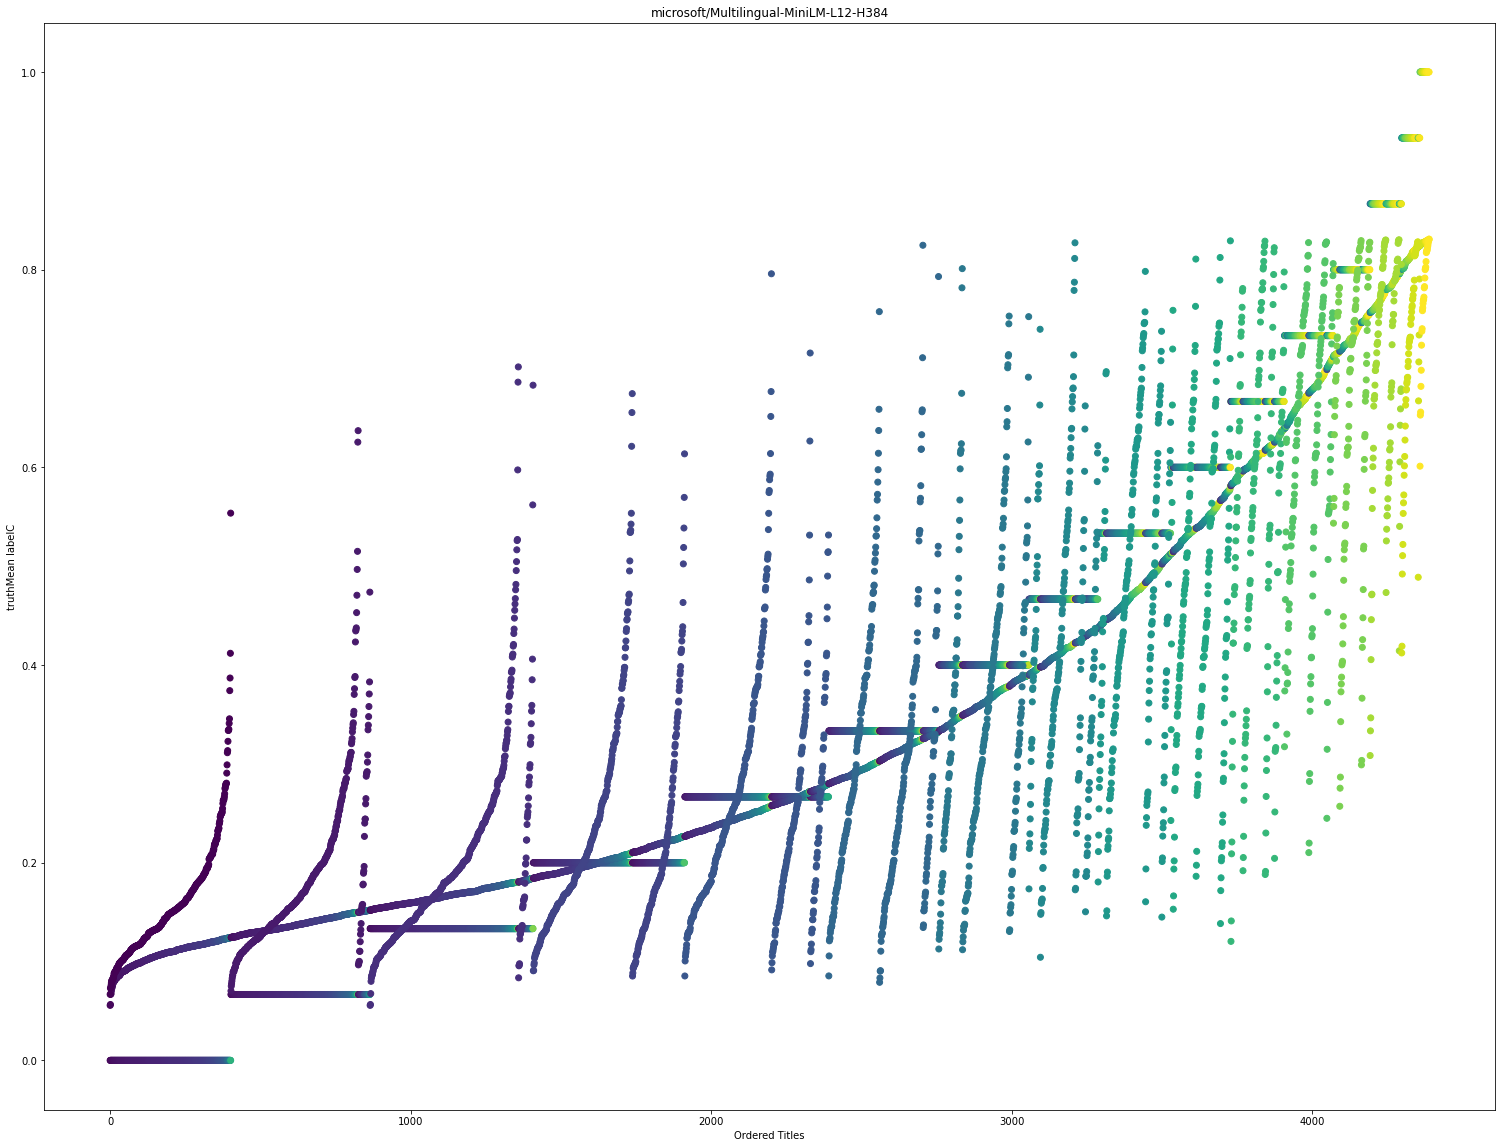

In [70]:
plt.figure(figsize=(26, 20))
plt.title(modelIn)
plt.xlabel("Ordered Titles")

plt.ylabel(actualOutput + " " + computedOutput)

x = np.array(range(0, tct1.shape[0]))
y = tct1[actualOutput]
plt.scatter(x, y, c = color1, marker = "o", label = "Array elements")

x2 = np.array(range(0, tct2.shape[0]))
y2 = tct2[computedOutput]
plt.scatter(x2, y2, c = color1, marker = "o", label = "Array elements")

x3 = np.array(range(0, tct1.shape[0]))
y3 = tct1[computedOutput]
plt.scatter(x3, y3, c = color2, marker = "o", label = "Array elements")


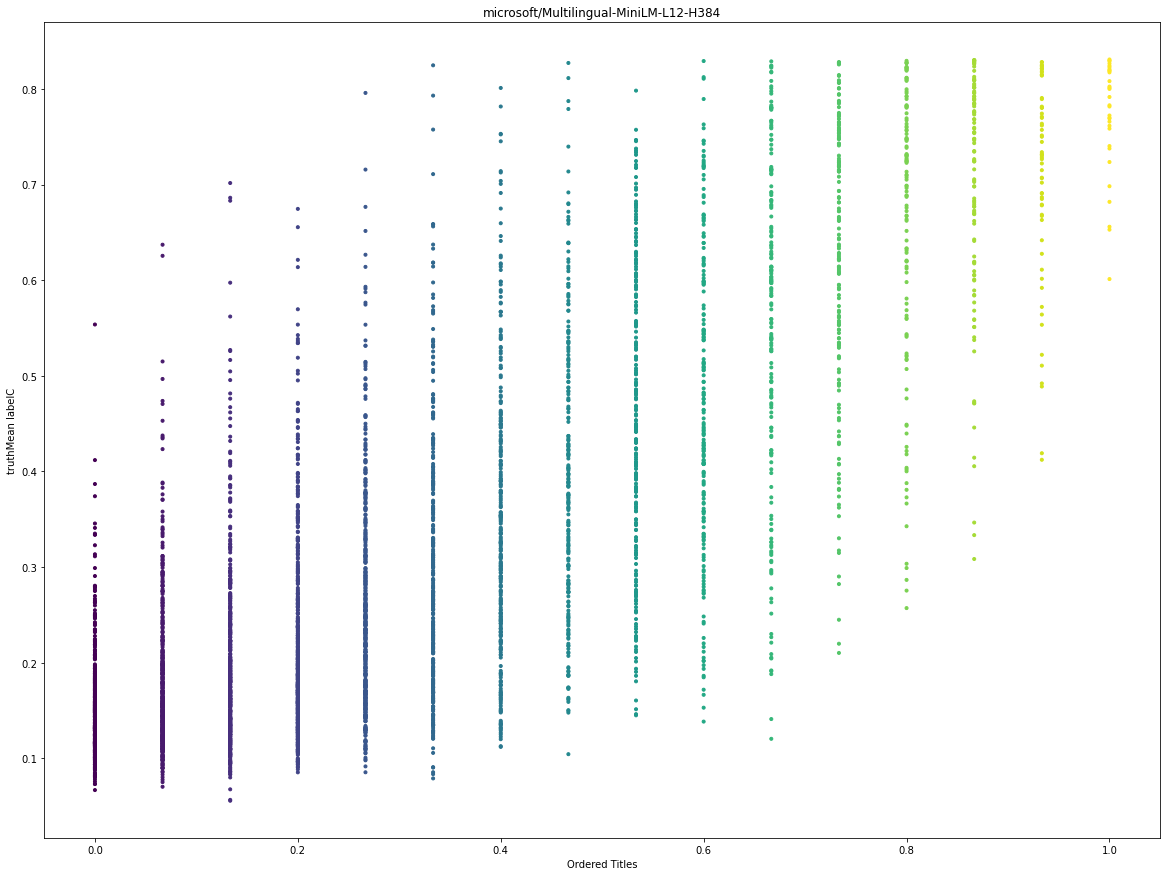

In [71]:
plt.figure(figsize=(20, 15))
plt.title(modelIn)
plt.xlabel("Ordered Titles")

plt.ylabel(actualOutput + " " + computedOutput)

x = np.array(range(0, tct1.shape[0]))
y = tct1[actualOutput]
# plt.scatter(x, y, c = color1, marker = "o", label = "Array elements")

x2 = np.array(range(0, tct2.shape[0]))
y2 = tct2[computedOutput]
# plt.scatter(x2, y2, c = color1, marker = "o", label = "Array elements")

x3 = tct1[actualOutput]
y3 = tct1[computedOutput]
plt.scatter(x3, y3, c = color2, marker = ".", label = "Array elements")

In [72]:
tct[[computedOutput, actualOutput]].describe()

,labelC,truthMean
count,4389.000000,4389.000000
mean,0.324694,0.329232
std,0.199901,0.251577
min,0.055647,0.000000
25%,0.164486,0.133333
50%,0.256671,0.266667
75%,0.438731,0.533333
max,0.830855,1.000000


In [73]:
tct.corr()

,truthMean,labels,labelC
truthMean,1.000000,1.000000,0.785808
labels,1.000000,1.000000,0.785808
labelC,0.785808,0.785808,1.000000
